### Initial run

Initial end to end test, a sort of a "teaser" to highlight the motivation for `concurrent_dataloader`. 

In [549]:
from benchmarking.analysis.analyze_results import *

In [550]:
output_base_folder = Path("/iarai/home/ivan.svogor/storage-benchmarking/benchmark_output/pl_test2")

In [551]:
# s3_folder_filter="1011_4/*benchmark_e2e*"
scratch_folder_filter="*benchmark_e2e_*"

Load the data

In [723]:
def timelines(df, run, lanes, colors, flat=False, zoom=False, zoom_epochs=1):
    start = min(df["start_time_x"])
    end = max(df["end_time_y"])
    if "torch" in run:
        colors["batch"] = "gold"
#     else:
#         colors["batch"] = "gold"

    total_runtime = end - start
    number_of_epochs = 20

    if zoom:
        df = df[df["start_time_x"] < start + ((total_runtime / number_of_epochs) * zoom_epochs)]

    i = 0
    for _, row in df.sort_values(["start_time_x"], ascending=True).iterrows():
        duration = row["end_time_y"] - row["start_time_x"]
        x1 = row["start_time_x"] - start
        x2 = x1 + duration
        if not flat:
            lane = i
            i += 1
        else:
            lane = lanes[row["item_x"]]
        ax.plot([x1, x2], [lane, lane], color=colors[row["item_x"]], label=row["item_x"], linewidth=2)
    ax.set_xlabel("Experiment duration", loc="center")
    ax.set_ylabel("Item", loc="top")
    filename = run.split("_")
    ax.set_title(
        f"Runtime for each function, impl: {filename[9]},"
        f" cache: {filename[8]}, "
        f" batch size: {filename[5]}, "
        f" lib: {filename[3]}",
        loc="center",
    )
    ax.legend()
    ax.grid(linestyle="--", which="both")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Put a legend below current axis
    ax.legend(
        by_label.values(),
        by_label.keys(),
        loc="upper center",
        bbox_to_anchor=(0.5, -0.05),
        fancybox=True,
        shadow=True,
        ncol=5,
    )


In [759]:
# df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 246.95it/s]


In [760]:
# df_dataloader_scratch

Create "colors" and "lanes". Colors are used to distinguish different function types, e.g. function that loads a batch, calls the `next_data`, `run_traning_batch` from Lightning and `training_batch_to_device` also from lightning.
Lanes, every single call of the aforementioned funcitons in their own respective lane, so we get a nice overview of when the function is called, and how long it tookl

In [761]:
unique_functions_scratch = np.unique(df_dataloader_scratch["item_x"])
unique_functions_scratch = np.sort(unique_functions_scratch)
print(f"Unique functions: {unique_functions_scratch}")

colors = {}
for i, color in zip(unique_functions_scratch, 
                    ["red", "blue", "green", "magenta", "orange", "lawngreen", "black", "gray", "teal"]):
    colors[str(i)] = color
# colors["run_training_batch"] = "aqua"
    
lanes={}
for i, lane in zip(unique_functions_scratch, range(len(unique_functions_scratch))):
    lanes[str(i)] = lane
    
print(f"Lanes: {lanes}")

# unique_runs_s3 = np.unique(df_dataloader_s3["run"])
unique_runs_scratch = np.unique(df_dataloader_scratch["run"])
print(unique_runs_scratch)

Unique functions: ['advance' 'batch' 'next_data' 'postrun_training_batch'
 'prep_training_batch' 'prerun' 'reset_timeline' 'run_training_batch'
 'training_batch_to_device']
Lanes: {'advance': 0, 'batch': 1, 'next_data': 2, 'postrun_training_batch': 3, 'prep_training_batch': 4, 'prerun': 5, 'reset_timeline': 6, 'run_training_batch': 7, 'training_batch_to_device': 8}
['20220210f233053_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync'
 '20220210f233104_benchmark_e2e_lightning_scratch_256_4_16_1_asyncio_sync']


Extract the GPU Utilization data

20220210f233053_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync


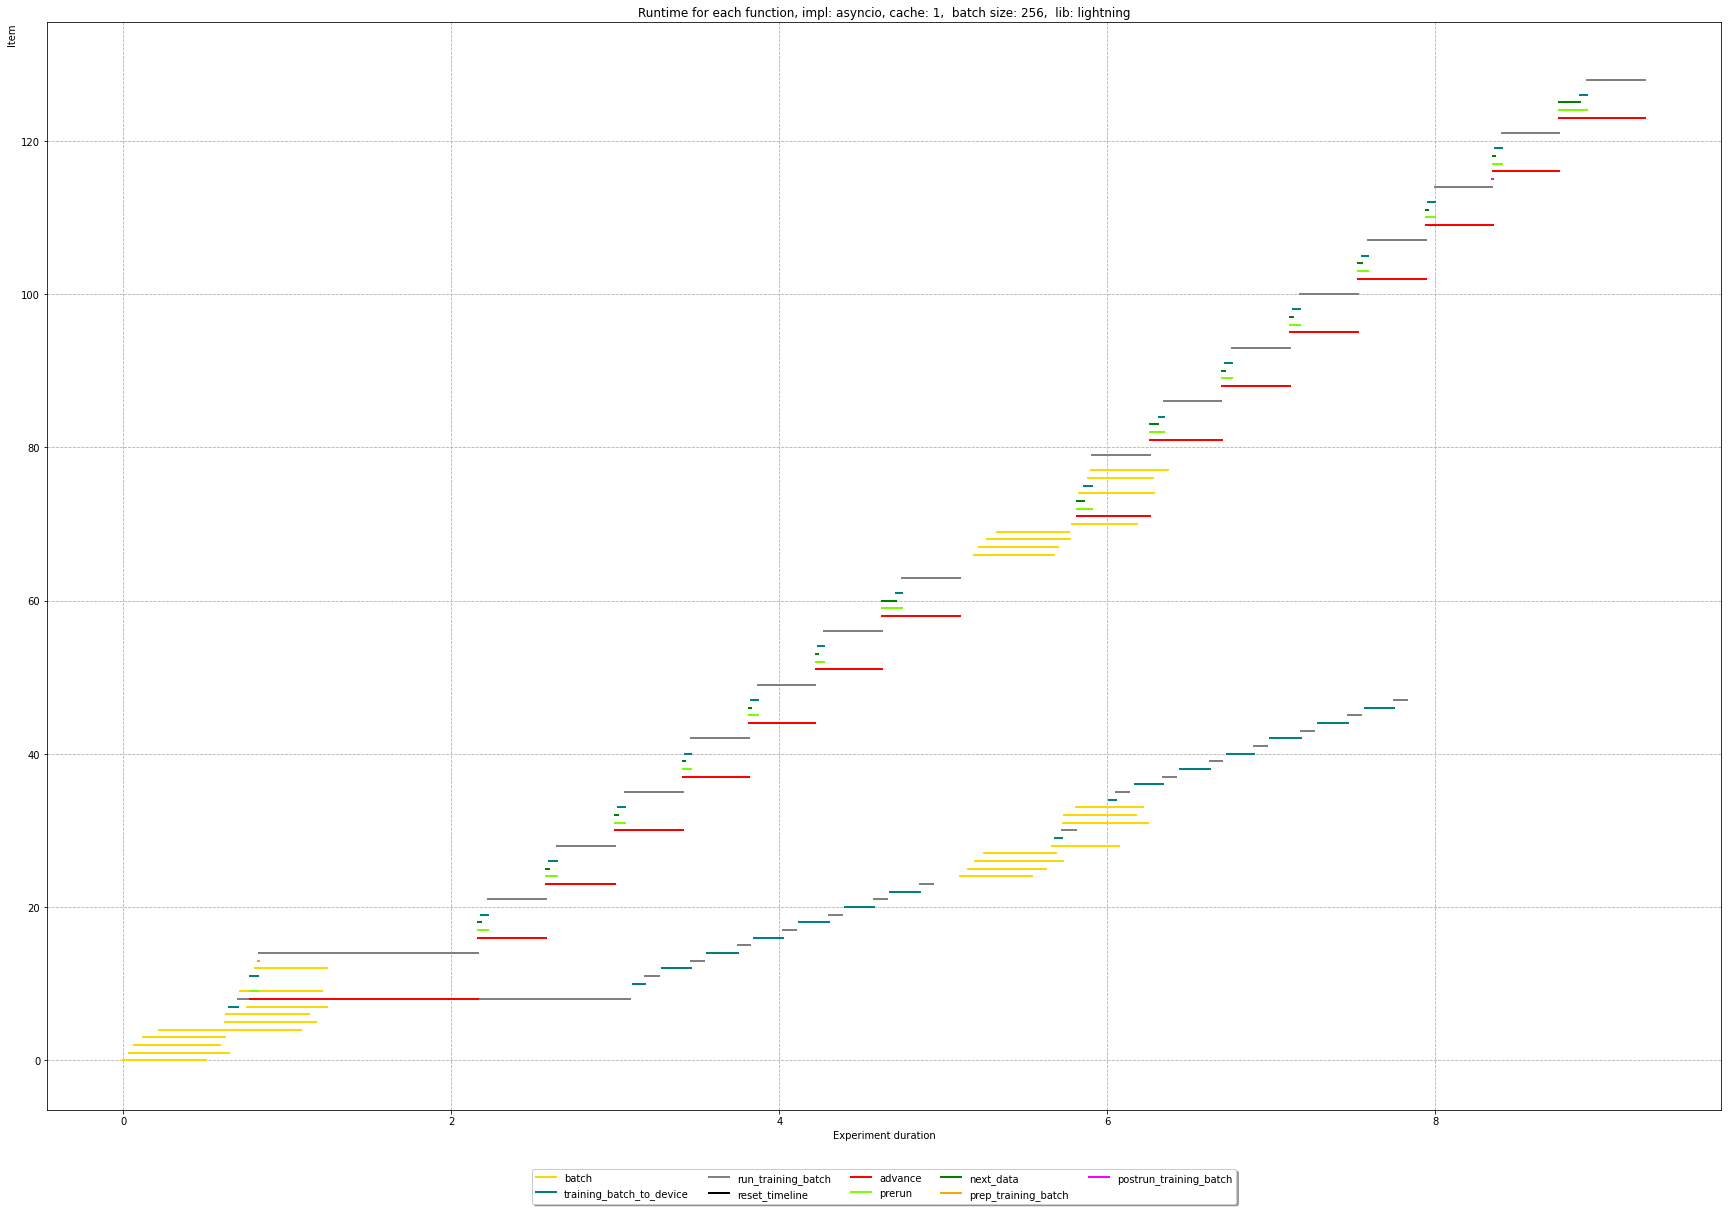

In [762]:
returns_scratch = []
function = "run_training_batch"
fig, ax = plt.subplots(figsize=(30, 20))
for run in sorted(unique_runs_scratch):
#     if "torch" in run:
    df = df_dataloader_scratch[(df_dataloader_scratch["run"]==run)]
    df.drop_duplicates(subset="id", keep="first", inplace=True) 
    returns_scratch.append(timelines(df, run, lanes, colors, False, False, 7))
#     break

# df = df_dataloader_scratch[(df_dataloader_scratch["run"]=="20220210f231309_benchmark_e2e_torch_scratch_256_4_16_1_asyncio_sync")]
# df.drop_duplicates(subset="id", keep="first", inplace=True)
# returns_scratch.append(timelines(df, run, lanes, colors, False, False, 6))